CHƯƠNG 5: HỒI QUY DỰ ĐOÁN MỨC ĐỘ HÀI LÒNG

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import json
import joblib

# Plotting configuration
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

LOAD DATA

In [3]:
df = pd.read_csv('../data/processed/data_normalized.csv')
with open('../data/processed/metadata.json', 'r') as f:
    metadata = json.load(f)

target_col = metadata['target_column']
y = df[target_col].values
X = df.drop(target_col, axis=1).values
feature_names = df.drop(target_col, axis=1).columns.tolist()

print(f"✓ Features: {X.shape[1]}, Samples: {X.shape[0]}")

✓ Features: 47, Samples: 1470


2. ĐỊNH NGHĨA MÔ HÌNH

In [4]:
print("\n[2] Defining models...")
models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0, random_state=42),
    'Lasso': Lasso(alpha=0.1, random_state=42),  # alpha nhỏ hơn để tránh zero coef
    'KNN': KNeighborsRegressor(n_neighbors=5),
    'MLP': MLPRegressor(
        hidden_layer_sizes=(100, 50),
        max_iter=500,
        random_state=42,
        early_stopping=True  # ← THÊM ĐỂ TRÁNH OVERFITTING
    )
}

print(f"✓ Models defined: {list(models.keys())}")


[2] Defining models...
✓ Models defined: ['Linear Regression', 'Ridge', 'Lasso', 'KNN', 'MLP']


3. TRAIN/TEST SPLITS

In [5]:
train_test_splits = [
    (0.8, 0.2, '80:20'),
    (0.7, 0.3, '70:30'),
    (0.6, 0.4, '60:40')
]

4. FUNCTION: TRAIN & EVALUATE

In [6]:
def train_and_evaluate(model, X_train, X_test, y_train, y_test):
    """Train model và compute metrics"""
    model.fit(X_train, y_train)

    # Predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Metrics
    train_mse = mean_squared_error(y_train, y_pred_train)
    test_mse = mean_squared_error(y_test, y_pred_test)

    train_rmse = np.sqrt(train_mse)
    test_rmse = np.sqrt(test_mse)

    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred_test)

    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)

    return {
        'train_mse': train_mse,
        'test_mse': test_mse,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_mae': train_mae,
        'test_mae': test_mae,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'y_pred_test': y_pred_test,
        'model': model
    }


RUN EXPERIMENTS - ORIGINAL DATA

In [7]:
results_original = []

for train_size, test_size, split_name in train_test_splits:
    print(f"\n  Split: {split_name}")

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42
    )

    for model_name, model in models.items():
        print(f"    Training {model_name}...", end=' ')

        try:
            metrics = train_and_evaluate(model, X_train, X_test, y_train, y_test)

            result = {
                'split': split_name,
                'model': model_name,
                'data_type': 'Original',
                'n_features': X.shape[1],
                **{k: v for k, v in metrics.items() if k not in ['y_pred_test', 'model']}
            }
            results_original.append(result)

            print(f"✓ RMSE={metrics['test_rmse']:.4f}, R²={metrics['test_r2']:.4f}")

        except Exception as e:
            print(f"✗ Error: {str(e)}")


  Split: 80:20
    Training Linear Regression... ✓ RMSE=1.1412, R²=-0.0303
    Training Ridge... ✓ RMSE=1.1410, R²=-0.0298
    Training Lasso... ✓ RMSE=1.1235, R²=0.0015
    Training KNN... ✓ RMSE=1.2455, R²=-0.2271
    Training MLP... ✓ RMSE=1.2099, R²=-0.1579

  Split: 70:30
    Training Linear Regression... ✓ RMSE=1.1271, R²=-0.0205
    Training Ridge... ✓ RMSE=1.1268, R²=-0.0200
    Training Lasso... ✓ RMSE=1.1156, R²=0.0001
    Training KNN... ✓ RMSE=1.2328, R²=-0.2209
    Training MLP... ✓ RMSE=1.1804, R²=-0.1194

  Split: 60:40
    Training Linear Regression... ✓ RMSE=1.1326, R²=-0.0448
    Training Ridge... ✓ RMSE=1.1320, R²=-0.0436
    Training Lasso... ✓ RMSE=1.1094, R²=-0.0024
    Training KNN... ✓ RMSE=1.2451, R²=-0.2626
    Training MLP... ✓ RMSE=1.2086, R²=-0.1897


6. RUN EXPERIMENTS - PCA REDUCED DATA

In [8]:
n_components = X.shape[1] // 3  # 15 components
results_pca = []

for train_size, test_size, split_name in train_test_splits:
    print(f"\n  Split: {split_name}")

    # ĐÚNG: Split trước, PCA sau
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42
    )

    # Fit PCA trên training set
    pca = PCA(n_components=n_components, random_state=42)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)  # Transform test set

    for model_name, model in models.items():
        print(f"    Training {model_name}...", end=' ')

        try:
            metrics = train_and_evaluate(model, X_train_pca, X_test_pca, y_train, y_test)

            result = {
                'split': split_name,
                'model': model_name,
                'data_type': 'PCA',
                'n_features': n_components,
                **{k: v for k, v in metrics.items() if k not in ['y_pred_test', 'model']}
            }
            results_pca.append(result)

            print(f"✓ RMSE={metrics['test_rmse']:.4f}, R²={metrics['test_r2']:.4f}")

        except Exception as e:
            print(f"✗ Error: {str(e)}")


  Split: 80:20
    Training Linear Regression... ✓ RMSE=1.1250, R²=-0.0012
    Training Ridge... ✓ RMSE=1.1250, R²=-0.0012
    Training Lasso... ✓ RMSE=1.1249, R²=-0.0010
    Training KNN... ✓ RMSE=1.2671, R²=-0.2700
    Training MLP... ✓ RMSE=1.2086, R²=-0.1555

  Split: 70:30
    Training Linear Regression... ✓ RMSE=1.1121, R²=0.0065
    Training Ridge... ✓ RMSE=1.1121, R²=0.0065
    Training Lasso... ✓ RMSE=1.1170, R²=-0.0024
    Training KNN... ✓ RMSE=1.2450, R²=-0.2452
    Training MLP... ✓ RMSE=1.2007, R²=-0.1582

  Split: 60:40
    Training Linear Regression... ✓ RMSE=1.1099, R²=-0.0032
    Training Ridge... ✓ RMSE=1.1099, R²=-0.0032
    Training Lasso... ✓ RMSE=1.1103, R²=-0.0040
    Training KNN... ✓ RMSE=1.2012, R²=-0.1750
    Training MLP... ✓ RMSE=1.2016, R²=-0.1758


7. COMBINE & SAVE RESULTS

In [9]:
print("\n[5] Saving results...")
df_results = pd.concat([
    pd.DataFrame(results_original),
    pd.DataFrame(results_pca)
], ignore_index=True)

df_results.to_csv('../results/metrics/regression_results_detailed.csv', index=False)


[5] Saving results...


8. SUMMARY TABLE

In [10]:
summary = df_results.groupby(['model', 'data_type'])[
    ['test_rmse', 'test_mae', 'test_r2']
].mean().round(4)

print(summary)

# Best model
best_idx = df_results['test_rmse'].idxmin()
best = df_results.loc[best_idx]
print(f"\n✓ BEST MODEL: {best['model']} ({best['data_type']})")
print(f"  RMSE: {best['test_rmse']:.4f}")
print(f"  R²: {best['test_r2']:.4f}")
print(f"  Split: {best['split']}")

                             test_rmse  test_mae  test_r2
model             data_type                              
KNN               Original      1.2411    1.0454  -0.2369
                  PCA           1.2377    1.0433  -0.2301
Lasso             Original      1.1162    0.9679  -0.0003
                  PCA           1.1174    0.9695  -0.0024
Linear Regression Original      1.1336    0.9627  -0.0318
                  PCA           1.1157    0.9572   0.0007
MLP               Original      1.1996    1.0211  -0.1557
                  PCA           1.2036    1.0292  -0.1632
Ridge             Original      1.1333    0.9624  -0.0311
                  PCA           1.1157    0.9572   0.0007

✓ BEST MODEL: Lasso (Original)
  RMSE: 1.1094
  R²: -0.0024
  Split: 60:40


9. VISUALIZATION

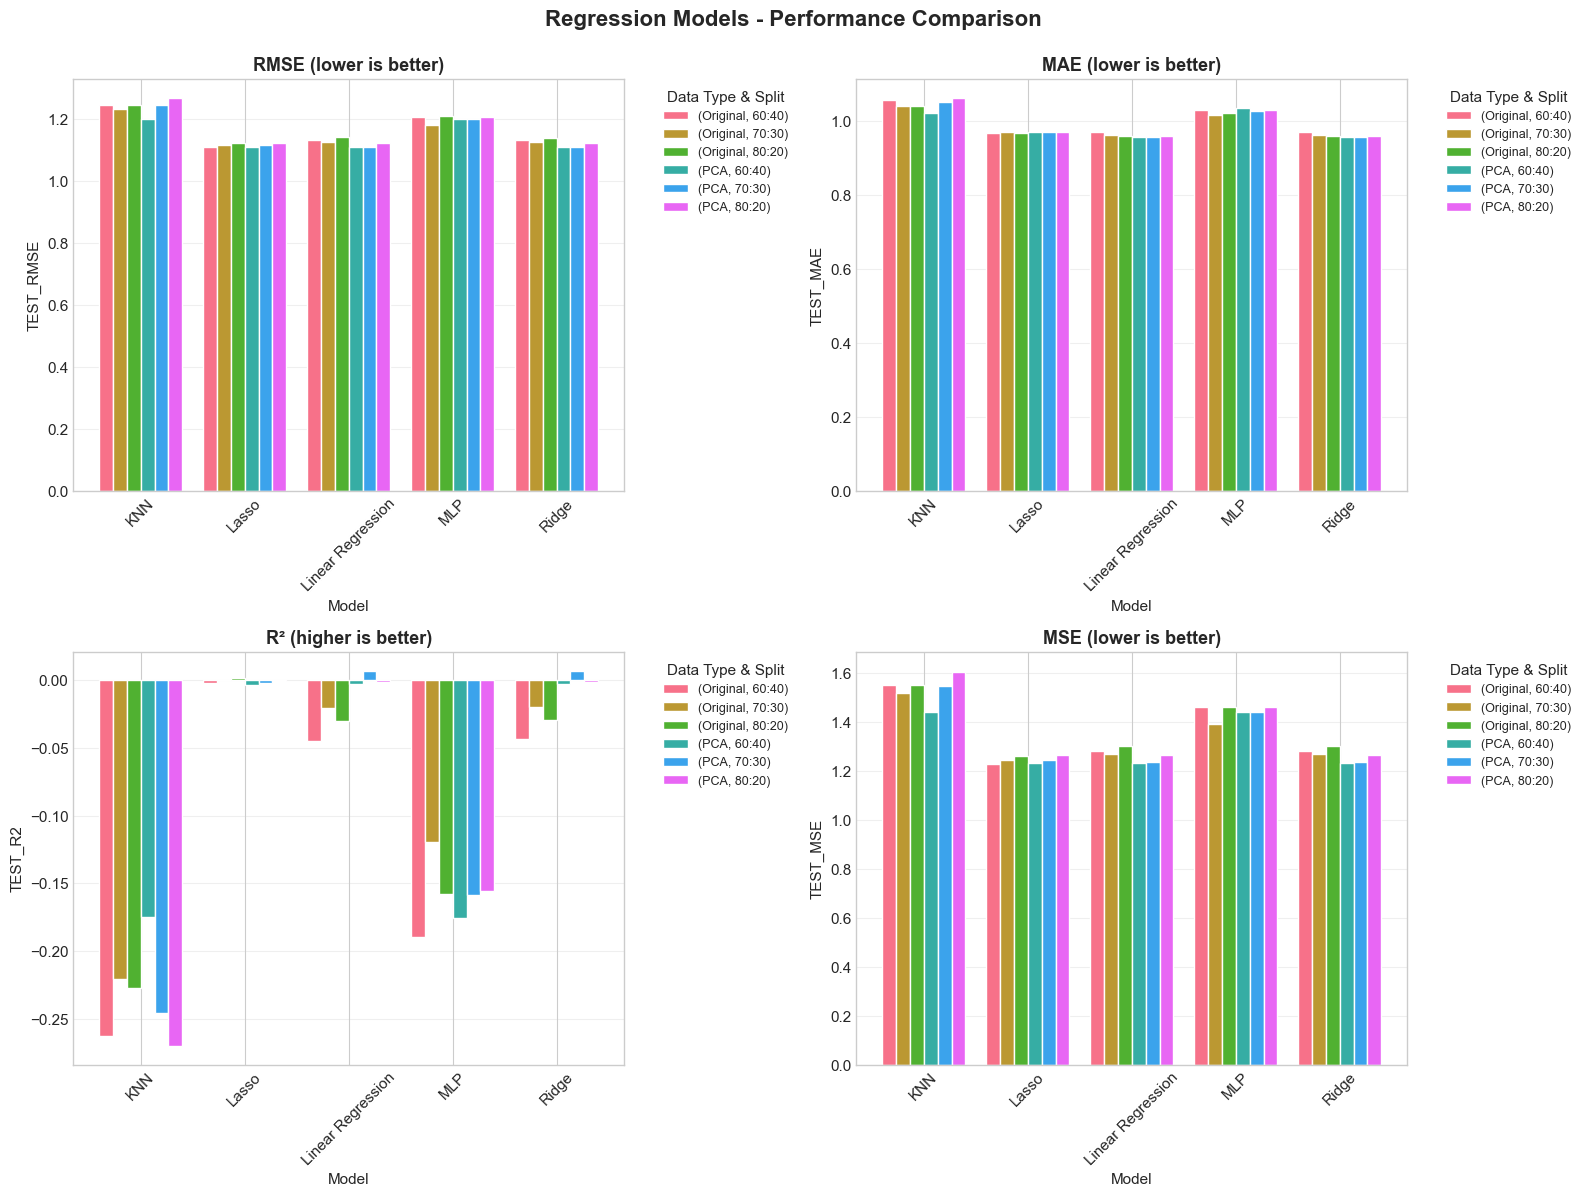

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics_to_plot = ['test_rmse', 'test_mae', 'test_r2', 'test_mse']
titles = ['RMSE (lower is better)', 'MAE (lower is better)',
          'R² (higher is better)', 'MSE (lower is better)']

for idx, (metric, title) in enumerate(zip(metrics_to_plot, titles)):
    ax = axes[idx // 2, idx % 2]

    pivot = df_results.pivot_table(
        values=metric,
        index='model',
        columns=['data_type', 'split']
    )

    pivot.plot(kind='bar', ax=ax, width=0.8)
    ax.set_title(title, fontsize=13, fontweight='bold')
    ax.set_ylabel(metric.upper(), fontsize=11)
    ax.set_xlabel('Model', fontsize=11)
    ax.legend(title='Data Type & Split', bbox_to_anchor=(1.05, 1), fontsize=9)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3, axis='y')

plt.suptitle('Regression Models - Performance Comparison',
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('../results/figures/regression/performance_comparison.png',
            dpi=300, bbox_inches='tight')
plt.show()

10. RESIDUALS ANALYSIS - BEST MODEL

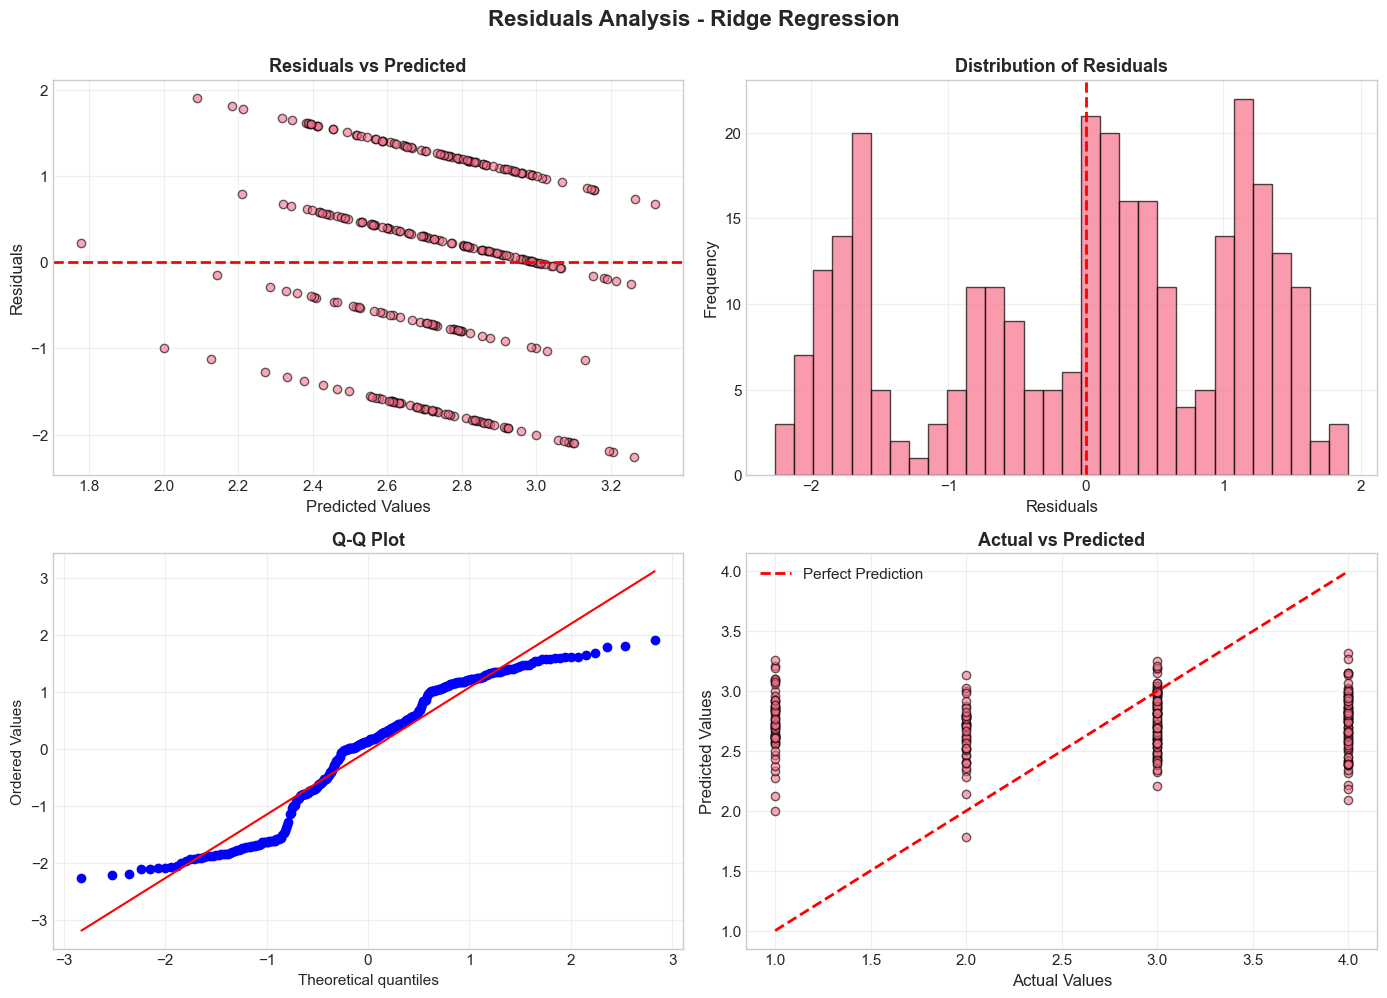

In [12]:
# Train best model với split 80:20
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Chọn Ridge (best model theo kết quả trước)
best_model = Ridge(alpha=1.0, random_state=42)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

residuals = y_test - y_pred

# Residual plots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Residuals vs Predicted
axes[0, 0].scatter(y_pred, residuals, alpha=0.6, edgecolor='black')
axes[0, 0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Predicted Values', fontsize=12)
axes[0, 0].set_ylabel('Residuals', fontsize=12)
axes[0, 0].set_title('Residuals vs Predicted', fontsize=13, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# 2. Histogram of residuals
axes[0, 1].hist(residuals, bins=30, edgecolor='black', alpha=0.7)
axes[0, 1].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Residuals', fontsize=12)
axes[0, 1].set_ylabel('Frequency', fontsize=12)
axes[0, 1].set_title('Distribution of Residuals', fontsize=13, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# 3. Q-Q plot
from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot', fontsize=13, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# 4. Actual vs Predicted
axes[1, 1].scatter(y_test, y_pred, alpha=0.6, edgecolor='black')
axes[1, 1].plot([y_test.min(), y_test.max()],
                [y_test.min(), y_test.max()],
                'r--', linewidth=2, label='Perfect Prediction')
axes[1, 1].set_xlabel('Actual Values', fontsize=12)
axes[1, 1].set_ylabel('Predicted Values', fontsize=12)
axes[1, 1].set_title('Actual vs Predicted', fontsize=13, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle('Residuals Analysis - Ridge Regression',
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('../results/figures/regression/residuals_analysis.png',
            dpi=300, bbox_inches='tight')
plt.show()

11. CROSS-VALIDATION

In [13]:
from sklearn.model_selection import cross_validate

cv_results = {}

for model_name, model in models.items():
    print(f"  {model_name}...", end=' ')

    cv_scores = cross_validate(
        model, X, y,
        cv=5,
        scoring=['neg_mean_squared_error', 'r2'],
        return_train_score=True
    )

    cv_results[model_name] = {
        'train_rmse': np.sqrt(-cv_scores['train_neg_mean_squared_error'].mean()),
        'test_rmse': np.sqrt(-cv_scores['test_neg_mean_squared_error'].mean()),
        'train_r2': cv_scores['train_r2'].mean(),
        'test_r2': cv_scores['test_r2'].mean(),
        'std_rmse': np.sqrt(-cv_scores['test_neg_mean_squared_error']).std()
    }

    print(f"✓ RMSE={cv_results[model_name]['test_rmse']:.4f} (±{cv_results[model_name]['std_rmse']:.4f})")

# Save CV results
df_cv = pd.DataFrame(cv_results).T
df_cv.to_csv('../results/metrics/regression_cv_results.csv')

  Linear Regression... ✓ RMSE=1.1181 (±0.0279)
  Ridge... ✓ RMSE=1.1178 (±0.0276)
  Lasso... ✓ RMSE=1.1030 (±0.0162)
  KNN... ✓ RMSE=1.2064 (±0.0259)
  MLP... ✓ RMSE=1.1720 (±0.0299)
